In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('DB_TIME_HISTORY.csv')
data0 = data.groupby('INST_NAME').get_group('ACTDB11')

In [3]:
#输入某一个实例的数据data，输出处理后的时间与缺失值datanew
def time_miss_fix(data):
    time = data['SNAP_PERIOD']
    time = [i[:15] for i in time]
    time = pd.to_datetime(time,format = '%Y-%m-%d-%H%M')
    time = list(time)
    
    #时间取整
    for i in range(len(time)):
        if time[i].minute>0 and time[i].minute<30:
            time[i] = time[i] - datetime.timedelta(minutes=time[i].minute) #向下
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30) #向上
        elif time[i].minute>30:
            time[i] = time[i] - datetime.timedelta(minutes=(time[i].minute-30))
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30)
    
    time_new = pd.date_range(min(time),max(time),freq='1800s')
    datanew = pd.DataFrame(index=time_new,columns=['DB_TIME'])  #生成完整的时间
    datanew.loc[time,'DB_TIME']=list(data['DB_TIME'])                               #根据时间填充取值
    datanew.loc[datanew['DB_TIME']<0,'DB_TIME']=np.nan                     #把负值当成缺失值
    
    datanew.loc[datanew['DB_TIME']>100,'DB_TIME']=np.nan                #把大于100的当成缺失值
    
    return datanew

In [4]:
series = time_miss_fix(data0).DB_TIME

In [5]:
np.where(series.isnull())

(array([ 1151,  1152,  2154, 12573, 14002, 15149, 15456, 24191, 25439,
        25440, 25441, 25442, 25443, 25445, 27791, 27886, 27887, 27888,
        27889, 27890, 27891, 27892, 27893, 27894, 27895, 27896, 27897,
        27898, 28775, 28776, 31180], dtype=int64),)

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


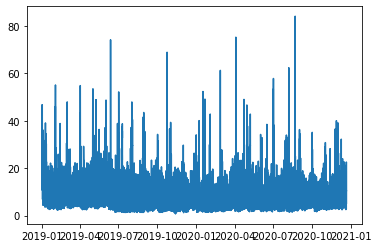

In [6]:
plt.plot(series)
plt.show()

In [7]:
#把时间序列数据转换为监督学习数据,n_in是X的维度,n_out是Y的维度
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)  自变量X
    for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)  因变量Y
    for i in range(0, n_out):
          cols.append(df.shift(-i))
    # put it all together  合并X和Y
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values  只要有缺失值，就删除那个样本
    if dropnan:
          agg.dropna(inplace=True)
    
    X = agg.values[:, :n_in]
    Y = agg.values[:,n_in:]
    
    return X, Y

In [8]:
dataX, dataY = series_to_supervised(series,48,1)

In [9]:
print(dataX.shape)
dataX

(33932, 48)


array([[19.55, 36.33, 28.35, ..., 10.97, 11.22, 10.92],
       [36.33, 28.35, 31.55, ..., 11.22, 10.92, 15.92],
       [28.35, 31.55, 33.29, ..., 10.92, 15.92, 15.4],
       ...,
       [6.69, 6.15, 5.41, ..., 21.02, 8.73, 6.86],
       [6.15, 5.41, 7.72, ..., 8.73, 6.86, 5.98],
       [5.41, 7.72, 7.83, ..., 6.86, 5.98, 5.58]], dtype=object)

In [10]:
print(dataY.shape)
dataY

(33932, 1)


array([[15.92],
       [15.4],
       [13.83],
       ...,
       [5.98],
       [5.58],
       [5.23]], dtype=object)

In [11]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [12]:
model.fit(dataX, dataY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [13]:
y_fit = model.predict(dataX)

In [14]:
model_std = (dataY.reshape(-1)-y_fit).std()

In [15]:
xpre = []
upr = []

for h in range(4800):
    x = series[h:h+48].values.reshape(1,-1)  #变成训练数据的输入格式(1,48)
    y = model.predict(x)[0]
    upr_h = y + 6 * model_std
    
    xpre.append(y)
    upr.append(upr_h)
    
    if np.isnan(series[h+48]):
        series[h+48] = y
    else :
        series[h+48] = min(upr_h,series[h+48])
    
upr_new = [max(upr[i-1],upr[i],upr[i+1]) for i in range(1,len(upr)-1)]

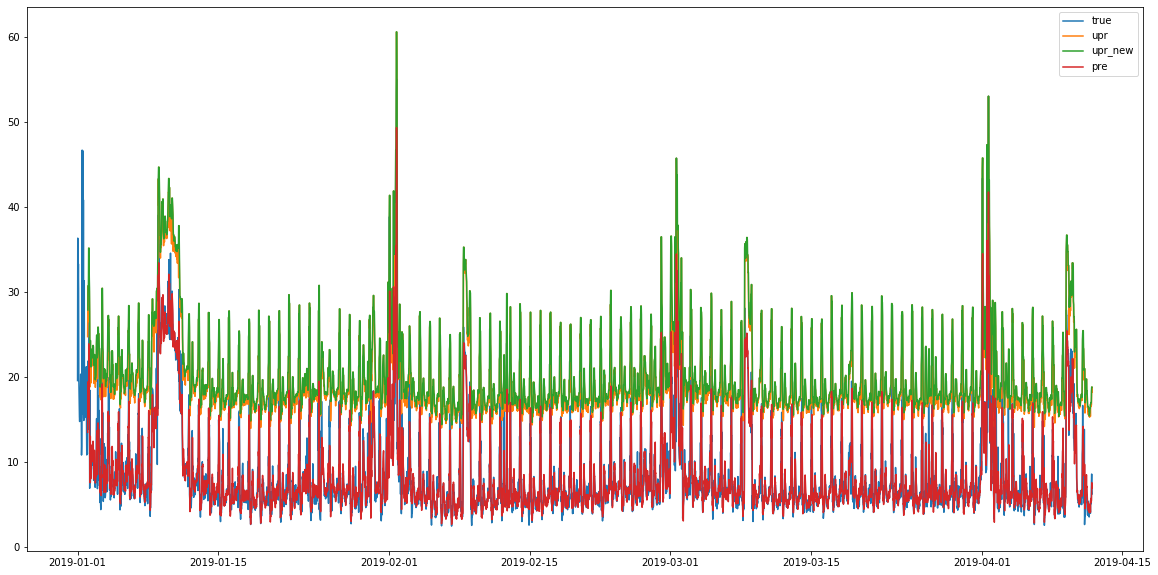

In [17]:
plt.figure(figsize=(20,10))
plt.plot(series.index[:4848],series[:4848],label='true')
plt.plot(series.index[48:4848],upr,label = 'upr')
plt.plot(series.index[49:4847],upr_new,label = 'upr_new')
plt.plot(series.index[48:4848],xpre,label = 'pre')
plt.legend()
plt.show()

In [89]:
#from scipy.signal import savgol_filter
#upr_1 = savgol_filter(upr_new,49,3) #Savitzky-Golay滤波器，窗口长度49（奇数），3次多项式

In [57]:
#把upr平滑一下 局部回归
#超过多少比例划分
#低于平均值的基线适当处理  窗口30天
#平滑后 高于平均值的替换掉

In [91]:
upr_smooth = pd.Series(upr_new).rolling(48).mean() #移动平均

In [168]:
i = 48
upr_fix = upr_new[:i]
while i < len(upr_new):
    upr_1 = upr_new[i:i+1440]
    upr_2 = list(upr_smooth[i:i+1440])
    upr_mean = np.mean(upr_1)
    upr_fix += [upr_1[j] if upr_1[j]>=upr_mean else upr_2[j] for j in range(len(upr_1))]
    i += 1440

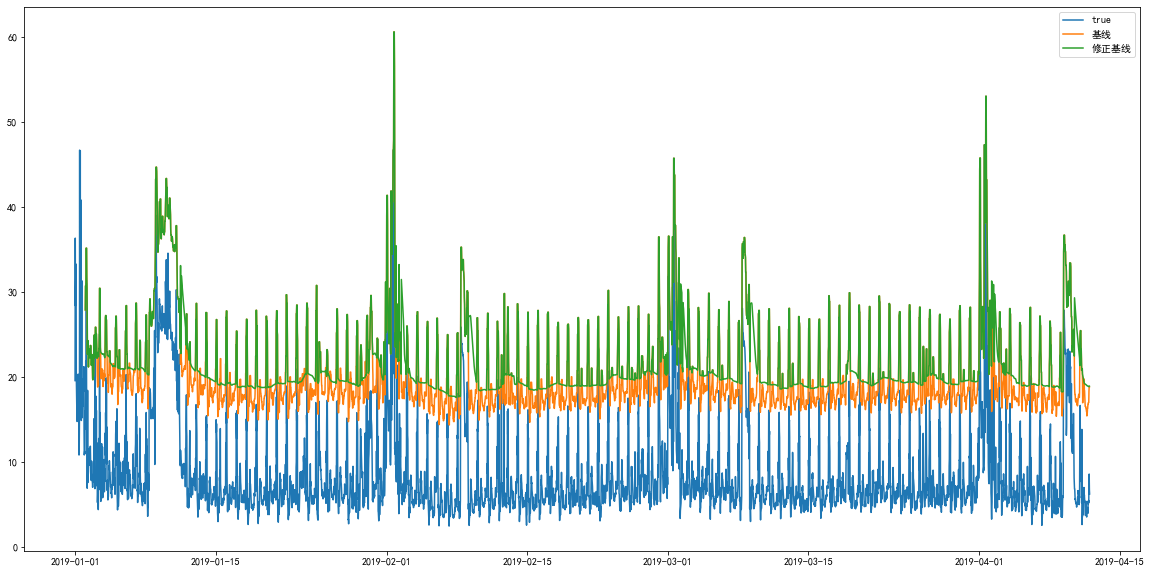

In [172]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,10))
plt.plot(series.index[:4848],series[:4848],label='true')
plt.plot(series.index[49:4847],upr_new,label = '基线')
plt.plot(series.index[49:4847],upr_fix,label = '修正基线')
plt.legend()
plt.show()